In [1]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm
import datetime
import time

base_path = 'stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16, 
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24, 
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6, 
 '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13, 
 'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20, 
 '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
 '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
 '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44, 
 '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52, 
 '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60, 
 '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68, 
 '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77, 
 '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85, 
 '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
 '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102, 
 '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

In [2]:
def JudgeST(x):
    if 'ST' in x:
        return 1
    else:
        return 0

def GetMA(df, col_name, rolling_day):
    tmp_array = df[col_name].values.reshape(-1)
    df.loc[ rolling_day:, col_name + '_'+str(rolling_day)] = (tmp_array[0:-rolling_day] - 
                                                              tmp_array[rolling_day:]) / tmp_array[0:-rolling_day]
    return df

col = ['ma'+str(i) for i in [5, 10, 13]] + ['ma_v_'+str(i) for i in [5, 10, 13]]

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding='ANSI')
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(['index', 'symbol', 'fullname'], axis=1, inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
index = ['000001.SH', '000016.SH', '000002.SH', '399001.SZ', '399007.SZ', '399008.SZ', '399101.SZ',
         '399102.SZ']
for ts_code in index:
    tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    # 特征工程
#         tmp_df = FeatureEngineering(tmp_df)
    stock_index_info = pd.concat((stock_index_info, tmp_df)) 
    break
#     transaction_day = len(tmp_df) 
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    except:
        pass
    
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index(drop=True)    
    for tmp_col in col:
        for rolling_day in [3]:
            tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
    
    

    tmp_list.append(tmp_df)
stock_info = pd.concat(tmp_list)
stock_info = stock_info.reset_index(drop=True)
ts_code_map = dict(zip(stock_info['ts_code'].unique(), range(stock_info['ts_code'].nunique())))


stock_info = stock_info.reset_index(drop=True)
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)

stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['ts_date_id'] = (10000 + stock_info['ts_code_id']) * 10000 + stock_info['trade_date_id']
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

100%|██████████| 2892/2892 [01:12<00:00, 39.81it/s]


In [3]:
stock_info = stock_info.drop_duplicates(subset=['ts_date_id'])
len(stock_info)

4345535

In [4]:
len(stock_info_copy)

4346519

# 特征工程

In [6]:
feature_col = []

In [7]:
# 获取月份 和 星期几
def get_weekday(x):
    x = str(x)
    return datetime.datetime.fromtimestamp(time.mktime(time.strptime(x, "%Y%m%d"))).weekday()
# stock_info['month'] = stock_info['trade_date'].apply(lambda x: int(str(x)[4:6]))
stock_info['weekday'] = stock_info['trade_date'].apply(get_weekday)
# feature_col.append('month')
feature_col.append('weekday')

In [8]:
# 添加涨跌停信息
limit_info = pd.read_csv('limit.csv')
limit_info.drop('file', axis=1, inplace=True)
limit_info['U-D'] = limit_info['U'] - limit_info['D']
limit_info = limit_info.rename(columns={'date':'trade_date'})
stock_info = stock_info.merge(limit_info[['U-D', 'trade_date']], on='trade_date', how='left')
feature_col.append('U-D')

In [9]:
# 求相对的vol 这里与21均线比较
stock_info['vol'] = (stock_info['vol'] - stock_info['ma_v_21']) / stock_info['ma_v_21']
feature_col.append('vol')

#转换low colse等
col = ['open', 'high', 'low', 'high', 'pre_close']
for tmp_col in col:
    stock_info[tmp_col+'_transform'] = (stock_info[tmp_col] - stock_info['ma5']) / stock_info['ma5']
    feature_col.append(tmp_col+'_transform')


In [10]:
# 添加大盘指数信息
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
for tmp_col in ['amount', 'pre_close']:
    tmp_df = tmp_df.rename(columns={tmp_col: tmp_col + '_index_000001'})
    stock_info = stock_info.merge(tmp_df[['trade_date', tmp_col + '_index_000001']], on='trade_date', how='left')

for tmp_col in ['amount_index_000001', 'pre_close_index_000001', 'amount', 'pre_close']:
    print(tmp_col)
    for i in range(3):
        tmp_df = stock_info[['ts_date_id', tmp_col]]
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        tmp_df = tmp_df.rename(columns={tmp_col:new_col_name})
        feature_col.append(new_col_name)
        tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
        stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
    for i in range(3):
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        stock_info[new_col_name] = (stock_info[tmp_col] - stock_info[new_col_name]) / stock_info[new_col_name]
#         feature_col.append(new_col_name)

amount_index_000001
pre_close_index_000001
amount
pre_close


In [34]:
# 添加资金流向
df_list = []
col = ['buy_md_vol', 'sell_md_vol', 'buy_lg_vol', 'sell_lg_vol', 
       'buy_elg_vol', 'sell_elg_vol', 'net_mf_vol'] #'buy_sm_vol', 'sell_sm_vol',
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path,  'MoneyData', ts_code + '.csv'))
    except:
        pass
    transform_col = []
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index(drop=True)  
    drop_col = []
#     tmp_df.drop(['buy_sm_amount', 'sell_sm_amount', 'buy_md_amount', 'sell_md_amount', 'buy_lg_amount', 'sell_lg_amount', 
#                 'buy_elg_amount', 'sell_elg_amount', 'net_mf_amount'])
    tmp_df['diff_md'] = tmp_df['buy_md_vol'] - tmp_df['sell_md_vol']
    tmp_df['diff_lg'] = tmp_df['buy_lg_vol'] - tmp_df['sell_lg_vol']
    tmp_df['diff_elg'] = tmp_df['buy_elg_vol'] - tmp_df['sell_elg_vol']
    rolling_day = 5
    for tmp_col in ['buy_md_vol', 'buy_lg_vol', 'buy_elg_vol', 'diff_md', 'diff_lg', 'diff_elg']:
        tmp_df[tmp_col+'_'+str(rolling_day)] = tmp_df[tmp_col].rolling(rolling_day).mean()
        tmp_df[tmp_col+'_transform'] = (tmp_df[tmp_col] - tmp_df[tmp_col+'_'+str(rolling_day)]) / tmp_df[tmp_col+'_'+str(rolling_day)]
        transform_col.append(tmp_col+'_transform')    
    transfom_col = ['buy_md_vol', 'buy_lg_vol', 'buy_elg_vol', 'diff_md', 'diff_lg', 'diff_elg']        
    for shift_day in [1, 2, 3]:
        for tmp_col in ['buy_md_vol', 'buy_lg_vol', 'buy_elg_vol', 'diff_md', 'diff_lg', 'diff_elg']:
            tmp_array = tmp_df[tmp_col].values.reshape(-1)
            tmp_df.loc[shift_day:, tmp_col + '_shift_'+str(shift_day)] = tmp_array[0:-shift_day]
            tmp_df[tmp_col + '_shift_'+str(shift_day)] = \
            (tmp_df[tmp_col + '_shift_'+str(shift_day)] - tmp_df[tmp_col+'_'+str(rolling_day)]) / tmp_df[tmp_col+'_'+str(rolling_day)]
            transform_col.append(tmp_col + '_shift_'+str(shift_day))    
    df_list.append(tmp_df[['trade_date', 'ts_code']+transform_col])
    
df_all = pd.concat(df_list)    

100%|██████████| 2892/2892 [02:53<00:00, 18.26it/s]


In [40]:
feature_col = feature_col + [tmp_col for tmp_col in df_all.columns if tmp_col not in['trade_date', 'ts_code']]

In [41]:
stock_info = stock_info.merge(df_all, on=['trade_date', 'ts_code'], how='left')

In [11]:
feature_col.append('turnover_rate')

In [43]:
stock_info.columns

Index(['trade_date', 'ts_code', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'turnover_rate', 'volume_ratio',
       'ma5', 'ma_v_5', 'ma10', 'ma_v_10', 'ma13', 'ma_v_13', 'ma21',
       'ma_v_21', 'ma30', 'ma_v_30', 'ma60', 'ma_v_60', 'ma120', 'ma_v_120',
       'ma5_3', 'ma10_3', 'ma13_3', 'ma_v_5_3', 'ma_v_10_3', 'ma_v_13_3',
       'ts_code_id', 'trade_date_id', 'ts_date_id', 'name', 'area', 'industry',
       'market', 'exchange', 'list_date', 'is_hs', 'is_ST', 'weekday', 'U-D',
       'open_transform', 'high_transform', 'low_transform',
       'pre_close_transform', 'amount_index_000001', 'pre_close_index_000001',
       'amount_index_000001_shift_1', 'amount_index_000001_shift_2',
       'amount_index_000001_shift_3', 'pre_close_index_000001_shift_1',
       'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3',
       'amount_shift_1', 'amount_shift_2', 'amount_shift_3',
       'pre_close_shift_1', 'pre_close_shift_2', '

# 标签制作

In [12]:
# make_label
# stock_info = stock_info_copy.copy()
use_col = []
for i in range(3):
    tmp_df = stock_info[['ts_date_id', 'high', 'low']]
    tmp_df = tmp_df.rename(columns={'high':'high_shift_{}'.format(i+1), 'low':'low_shift_{}'.format(i+1)})
    use_col.append('high_shift_{}'.format(i+1))
    use_col.append('low_shift_{}'.format(i+1))
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] - i - 1
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')

stock_info.dropna(inplace=True)

for i in range(3):
    stock_info['high_shift_{}'.format(i+1)] = (stock_info['high_shift_{}'.format(i+1)] - stock_info['close']) / stock_info['close']
    stock_info['low_shift_{}'.format(i+1)] = (stock_info['low_shift_{}'.format(i+1)] - stock_info['close']) / stock_info['close']

In [13]:
tmp_array = stock_info[use_col].values
max_increse = np.max(tmp_array, axis=1)
min_increse = np.min(tmp_array, axis=1)
stock_info['label_max'] = max_increse
stock_info['label_min'] = min_increse
stock_info['label_final'] = (stock_info['label_max'] > 0.06) & (stock_info['label_min'] > -0.03)
stock_info['label_final'] = stock_info['label_final'].apply(lambda x: int(x))

stock_info = stock_info.reset_index(drop=True)
# stock_info.drop('index', axis=1, inplace=True)

In [239]:
feature_col=['weekday', 'U-D', 'vol', 'open_transform', 'high_transform', 'low_transform', 'high_transform', 'pre_close_transform', 
 'amount_index_000001_shift_1', 'amount_index_000001_shift_2', 'amount_index_000001_shift_3', 'pre_close_index_000001_shift_1', 
 'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3', 'amount_shift_1', 'amount_shift_2', 'amount_shift_3',
 'pre_close_shift_1', 'pre_close_shift_2', 'pre_close_shift_3', 'turnover_rate', 'buy_md_vol_shift_1', 'buy_lg_vol_shift_1', 
 'buy_elg_vol_shift_1', 'diff_md_shift_1', 'diff_lg_shift_1', 'diff_elg_shift_1', 'buy_md_vol_shift_2', 'buy_lg_vol_shift_2', 
 'buy_elg_vol_shift_2', 'diff_md_shift_2', 'diff_lg_shift_2', 'diff_elg_shift_2']

# 'buy_md_vol_shift_1', 'buy_lg_vol_shift_1', 
#  'buy_elg_vol_shift_1', 'diff_md_shift_1', 'diff_lg_shift_1', 'diff_elg_shift_1', 'buy_md_vol_shift_2', 'buy_lg_vol_shift_2', 
#  'buy_elg_vol_shift_2', 'diff_md_shift_2', 'diff_lg_shift_2', 'diff_elg_shift_2', 'buy_md_vol_shift_3', 'buy_lg_vol_shift_3', 
#  'buy_elg_vol_shift_3', 'diff_md_shift_3', 'diff_lg_shift_3', 'diff_elg_shift_3'

# 'buy_md_vol_transform', 'buy_lg_vol_transform',
#  'buy_elg_vol_transform', 'diff_md_transform', 'diff_lg_transform', 'diff_elg_transform', 

In [240]:
print(feature_col)

['weekday', 'U-D', 'vol', 'open_transform', 'high_transform', 'low_transform', 'high_transform', 'pre_close_transform', 'amount_index_000001_shift_1', 'amount_index_000001_shift_2', 'amount_index_000001_shift_3', 'pre_close_index_000001_shift_1', 'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3', 'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'pre_close_shift_1', 'pre_close_shift_2', 'pre_close_shift_3', 'turnover_rate', 'buy_md_vol_shift_1', 'buy_lg_vol_shift_1', 'buy_elg_vol_shift_1', 'diff_md_shift_1', 'diff_lg_shift_1', 'diff_elg_shift_1', 'buy_md_vol_shift_2', 'buy_lg_vol_shift_2', 'buy_elg_vol_shift_2', 'diff_md_shift_2', 'diff_lg_shift_2', 'diff_elg_shift_2']


# 模型训练

In [335]:

trn_col = feature_col
# 'high', 'low', 'close', 'pre_close',
trn_col = list(set(trn_col))
label = 'label_final'
# trn_date_min = 20170103
# trn_date_max = 20190416
# val_date_min = 20190417
# val_date_max = 20190429
# test_date_min = 20190417
# test_date_max = 20191218

trn_date_min = 20170103
trn_date_max = 20190101
val_date_min = 20190101
val_date_max = 20190419
test_date_min = 20190101
test_date_max = 20191218

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max) & (stock_info['high']!=stock_info['close'])
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col]
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col]
val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col]
test_label = stock_info[test_data_idx][label].values

In [302]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))

rate of 0: 0.8942, rate of 1: 0.1058
trn data:1130149, val data:24710, test data:655822
number of features:32


In [303]:
def win_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.round(preds)
    tp = np.sum((preds==1)&(labels==1))
    pp = np.sum(preds==1)
    scores = tp/(pp+0.001) + 2.5*tp - pp
#     preds = np.argmax(preds.reshape(3, -1), axis=0)
#     scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'win', scores, True

In [387]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.06,
         "boosting": "gbdt",
#          "bagging_freq": 1,
#          "bagging_seed": 11,
         "metric": 'None',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round =1000
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
#                 early_stopping_rounds=300, feval=win_score_eval)
clf = lgb.train(param, trn_data, num_round, verbose_eval=300)
# oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

In [352]:
len(feature_col)

33

In [398]:
pd.DataFrame({
        'column': trn_col,
        'importance': clf.feature_importance(),
    }).sort_values(by='importance', ascending=False)

,column,importance
8,amount_index_000001_shift_1,1490
17,pre_close_index_000001_shift_1,1419
21,U-D,1405
11,amount_index_000001_shift_2,1381
13,turnover_rate,1321
19,pre_close_index_000001_shift_3,1263
22,pre_close_index_000001_shift_2,1235
24,amount_index_000001_shift_3,1224
4,high_transform,1126
1,low_transform,1120


# 模型评价

In [356]:
# oof_lgb_final = np.round(oof_lgb)
# print(metrics.accuracy_score(val_label, oof_lgb_final))
# print(metrics.confusion_matrix(val_label, oof_lgb_final))
# tp = np.sum(((oof_lgb_final == 1) & (val_label == 1)))
# pp = np.sum(oof_lgb_final == 1)
# print('sensitivity:%.3f'% (tp/(pp)))

In [388]:
thresh_hold = 0.5
# oof_test_final = (test_lgb >= 0.69) & (test_lgb <=0.7)
oof_test_final = test_lgb >= thresh_hold
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('sensitivity:%.3f'% (tp/(pp)))

0.8496634757601911
[[557102    272]
 [ 98322    126]]
sensitivity:0.317


In [389]:
test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
# test_postive_idx = list(range(len(oof_test_final)))
test_all_idx = np.argwhere(test_data_idx).reshape(-1)

In [390]:
# 查看选了哪些股票
tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_max', 'label_min', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
tmp_df['label_prob'] = test_lgb[test_postive_idx]
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [309]:
# print(len(buy_df), sum(buy_df['label_final']))

# 回测

In [391]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [392]:
tmp_idx = (index_df['trade_date'] == test_date_min+1)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [393]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init, max_hold_period=3)
account.BackTest(buy_df, stock_info_copy, index_df)

20190311  买入 德生科技 (002908.SZ) 1400股，股价：13.9418,花费：19518.52,手续费：5.86，剩余现金：80475.62
20190311  买入 粤传媒 (002181.SZ) 3200股，股价：6.1657,花费：19730.24,手续费：5.92，剩余现金：60739.47
20190311  买入 冀东装备 (000856.SZ) 1200股，股价：15.57,花费：18684.0,手续费：5.61，剩余现金：42049.86
20190311  买入 广电网络 (600831.SH) 2200股，股价：8.892999999999999,花费：19564.6,手续费：5.87，剩余现金：22479.39
20190311  买入 中光学 (002189.SZ) 900股，股价：21.766,花费：19589.4,手续费：5.88，剩余现金：2884.11
20190312  止盈卖出中光学 (002189.SZ) 900股，股价：22.8543,收入：20568.87,手续费：26.74，剩余现金：23426.24，最终盈利：946.85
20190312  止盈卖出广电网络 (600831.SH) 2200股，股价：9.33765,收入：20542.83,手续费：26.71，剩余现金：43942.37，最终盈利：945.65
20190312  止盈卖出冀东装备 (000856.SZ) 1200股，股价：16.3485,收入：19618.2,手续费：25.5，剩余现金：63535.07，最终盈利：903.09
20190312  止盈卖出粤传媒 (002181.SZ) 3200股，股价：6.473985000000001,收入：20716.75,手续费：26.93，剩余现金：84224.89，最终盈利：953.66
20190312  止盈卖出德生科技 (002908.SZ) 1400股，股价：14.6554,收入：20517.56,手续费：26.67，剩余现金：104715.77，最终盈利：966.51
20190318  买入 中国软件 (600536.SH) 400股，股价：47.2564,花费：18902.56,手续费：5.67，剩余现金：85807.54
20190318  买入 奥飞娱乐 (00229

In [394]:
tmp_df2 = buy_df[['ts_code', 'trade_date', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'})
tmp_df = account.info
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

In [395]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.1329
上证指数浮动情况:0.2238
交易胜率:0.6585
最大回撤率:0.0248


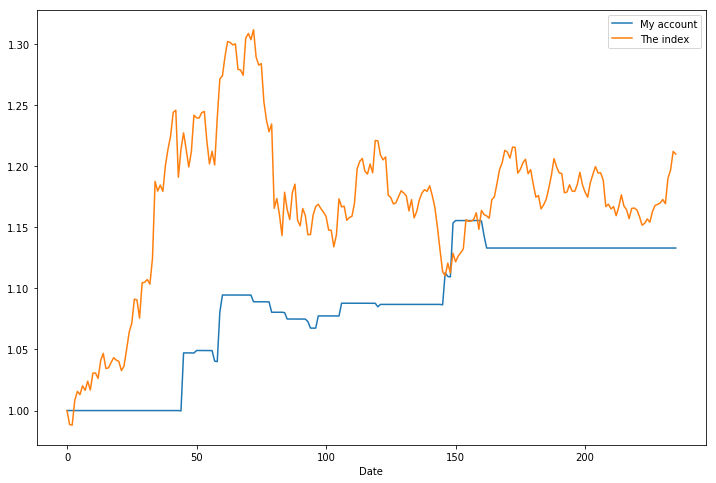

In [396]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min+1]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

E:\code\venv2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


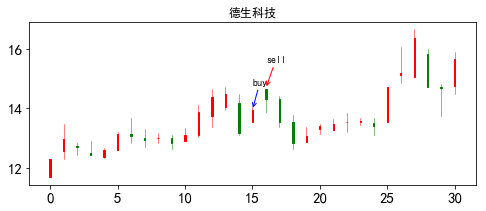

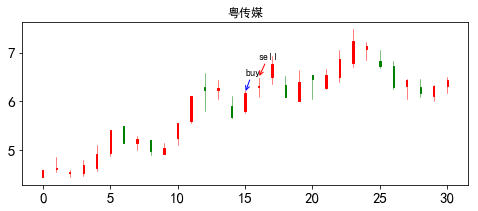

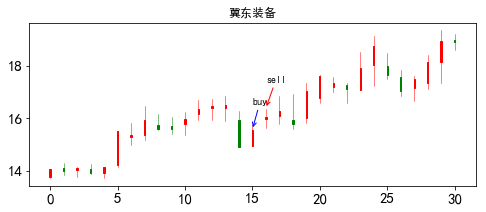

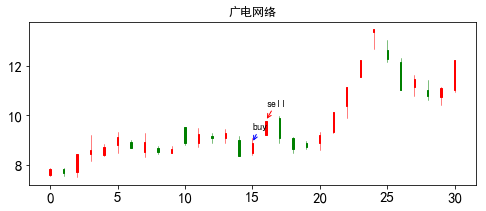

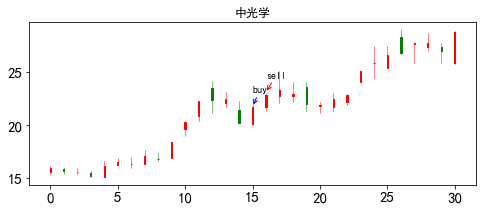

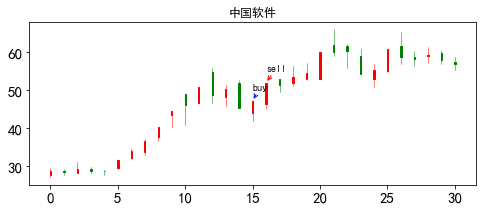

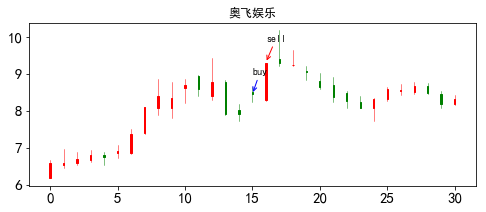

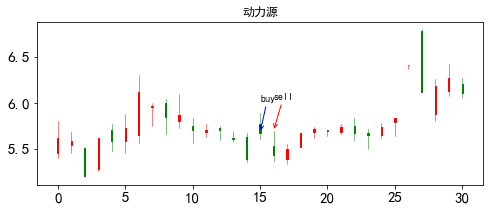

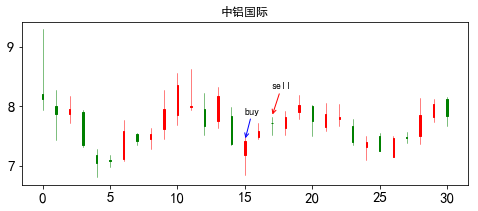

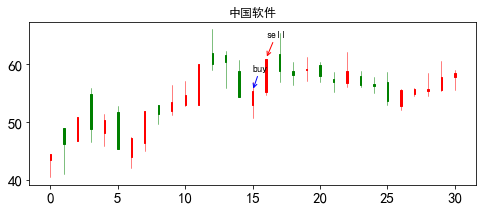

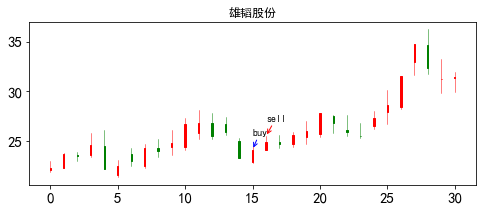

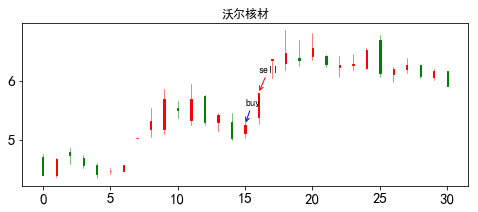

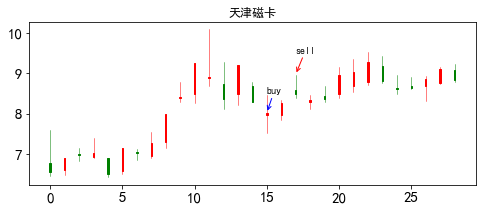

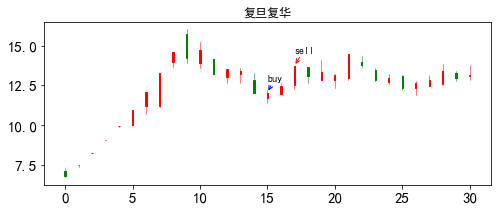

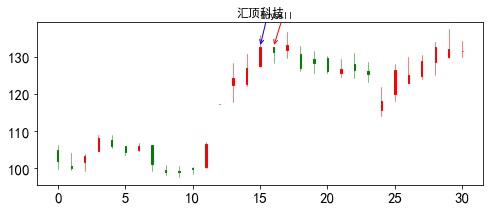

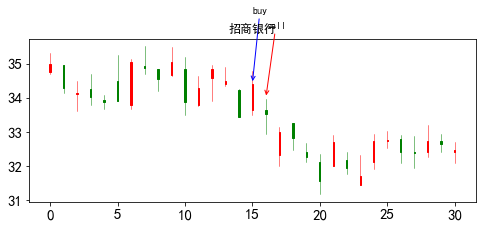

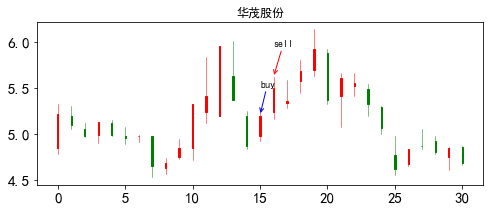

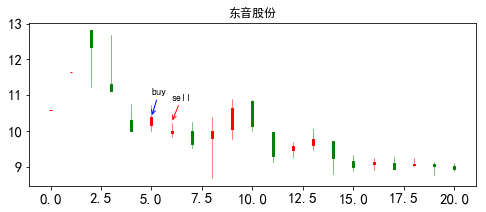

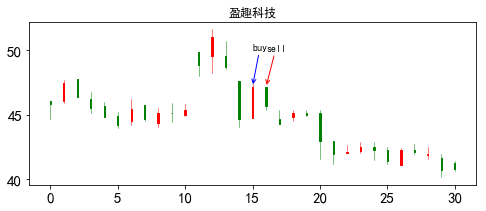

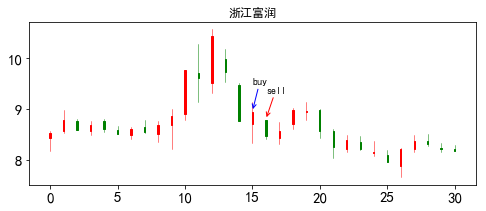

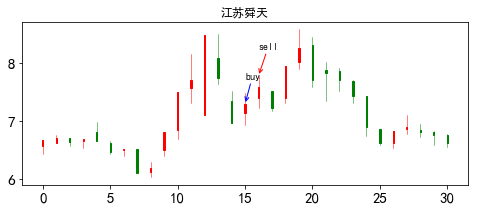

In [397]:
num = 0
for ts_code, buy_date, sell_date in zip(account.info['ts_code'], account.info['buy_date'], account.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=15, right_offset=15)
    num = num + 1
    if num > 20:
        break